In [32]:
#모듈 호출
import os
import pandas as pd
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import random
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

In [34]:
# 예측 문서 추출
def select_MPB(target_date):
    start_date = "2013-05-09"
    def date_range(start, end):
        start = datetime.strptime(start, "%Y-%m-%d")
        end = datetime.strptime(end, "%Y-%m")
        before_one_day = end - relativedelta(days=30)
        dates = [(start + timedelta(days=i)).strftime("%Y-%m-%d") for i in range((before_one_day-start).days+1)]
        return dates

    dates = date_range(start_date, target_date)

    path = "./MPB_crawling_dataset"
    file_list = []
    if os.path.isdir(path):
        text_list = os.listdir(path)
        for i in text_list:
            if i[-3:] == "txt":
                target_file = i[:-4]
                if target_file in dates:
                    file_list.append(i)
    MPB_file = file_list[-1]                
    f = open(f"{path}/{MPB_file}", 'r')
    file_text = f.readline()
    return file_text

target_date = "2015-07" #예측 날짜
file_text = select_MPB(target_date)
print("file_text 생성")


file_text 생성


In [30]:
#훈련데이터 불러오기
train_df = pd.read_csv("./train_df.csv")
train_df

,words,label,1_ngrams,2_ngrams,3_ngrams,4_ngrams,5_ngrams,new_column
0,월 기점 채권 금리 하락세 변곡점 형성 전망 요약 결론 추가 금리 인하 불확실성 경...,doveish,월 기점 채권 금리 하락세 변곡점 형성 전망 요약 결론 추가 금리 인하 불확실성 경...,월_기점 기점_채권 채권_금리 금리_하락세 하락세_변곡점 변곡점_형성 형성_전망 전...,월_기점_채권 기점_채권_금리 채권_금리_하락세 금리_하락세_변곡점 하락세_변곡점_...,월_기점_채권_금리 기점_채권_금리_하락세 채권_금리_하락세_변곡점 금리_하락세_변...,월_기점_채권_금리_하락세 기점_채권_금리_하락세_변곡점 채권_금리_하락세_변곡점_...,월 기점 채권 금리 하락세 변곡점 형성 전망 요약 결론 추가 금리 인하 불확실성 경...
1,일 금리 인하 요약 월기 금리 인하 이후 도금 통 위 기대감 지속 월금 통 위 글로...,doveish,일 금리 인하 요약 월기 금리 인하 이후 도금 통 위 기대감 지속 월금 통 위 글로...,일_금리 금리_인하 인하_요약 요약_월기 월기_금리 금리_인하 인하_이후 이후_도금...,일_금리_인하 금리_인하_요약 인하_요약_월기 요약_월기_금리 월기_금리_인하 금리...,일_금리_인하_요약 금리_인하_요약_월기 인하_요약_월기_금리 요약_월기_금리_인하...,일_금리_인하_요약_월기 금리_인하_요약_월기_금리 인하_요약_월기_금리_인하 요약...,일 금리 인하 요약 월기 금리 인하 이후 도금 통 위 기대감 지속 월금 통 위 글로...
2,월금 통 위 이후 향후 금리 방향 점검 요약 지난주 기준금리 인하 결정 채권시장 약...,doveish,월금 통 위 이후 향후 금리 방향 점검 요약 지난주 기준금리 인하 결정 채권시장 약...,월금_통 통_위 위_이후 이후_향후 향후_금리 금리_방향 방향_점검 점검_요약 요약...,월금_통_위 통_위_이후 위_이후_향후 이후_향후_금리 향후_금리_방향 금리_방향_...,월금_통_위_이후 통_위_이후_향후 위_이후_향후_금리 이후_향후_금리_방향 향후_...,월금_통_위_이후_향후 통_위_이후_향후_금리 위_이후_향후_금리_방향 이후_향후_...,월금 통 위 이후 향후 금리 방향 점검 요약 지난주 기준금리 인하 결정 채권시장 약...
3,강세 준비 숨고르기 요약 강세 준비 숨고르기 금주 채권 금리 월금 통 위 이후 추가...,doveish,강세 준비 숨고르기 요약 강세 준비 숨고르기 금주 채권 금리 월금 통 위 이후 추가...,강세_준비 준비_숨고르기 숨고르기_요약 요약_강세 강세_준비 준비_숨고르기 숨고르기...,강세_준비_숨고르기 준비_숨고르기_요약 숨고르기_요약_강세 요약_강세_준비 강세_준...,강세_준비_숨고르기_요약 준비_숨고르기_요약_강세 숨고르기_요약_강세_준비 요약_강...,강세_준비_숨고르기_요약_강세 준비_숨고르기_요약_강세_준비 숨고르기_요약_강세_준...,강세 준비 숨고르기 요약 강세 준비 숨고르기 금주 채권 금리 월금 통 위 이후 추가...
4,미국 금리 급등 스캔들 요약 이번 주채 시장 전망 약화 정책 기대 미국 금리 급등 ...,doveish,미국 금리 급등 스캔들 요약 이번 주채 시장 전망 약화 정책 기대 미국 금리 급등 ...,미국_금리 금리_급등 급등_스캔들 스캔들_요약 요약_이번 이번_주채 주채_시장 시장...,미국_금리_급등 금리_급등_스캔들 급등_스캔들_요약 스캔들_요약_이번 요약_이번_주...,미국_금리_급등_스캔들 금리_급등_스캔들_요약 급등_스캔들_요약_이번 스캔들_요약_...,미국_금리_급등_스캔들_요약 금리_급등_스캔들_요약_이번 급등_스캔들_요약_이번_주...,미국 금리 급등 스캔들 요약 이번 주채 시장 전망 약화 정책 기대 미국 금리 급등 ...
...,...,...,...,...,...,...,...,...
154441,표 행간 단기 금리 기준 코리보 일 다음 일 전시 고시 한국 은행 단기 금리 기준 ...,hawkish,표 행간 단기 금리 기준 코리보 일 다음 일 전시 고시 한국 은행 단기 금리 기준 ...,표_행간 행간_단기 단기_금리 금리_기준 기준_코리보 코리보_일 일_다음 다음_일 ...,표_행간_단기 행간_단기_금리 단기_금리_기준 금리_기준_코리보 기준_코리보_일 코...,표_행간_단기_금리 행간_단기_금리_기준 단기_금리_기준_코리보 금리_기준_코리보_...,표_행간_단기_금리_기준 행간_단기_금리_기준_코리보 단기_금리_기준_코리보_일 금...,표 행간 단기 금리 기준 코리보 일 다음 일 전시 고시 한국 은행 단기 금리 기준 ...
154442,채권 오전 금리 상승국 고년 입찰 여파 기자 국고채 금리 오전 중 상승 채권시장 따...,hawkish,채권 오전 금리 상승국 고년 입찰 여파 기자 국고채 금리 오전 중 상승 채권시장 따...,채권_오전 오전_금리 금리_상승국 상승국_고년 고년_입찰 입찰_여파 여파_기자 기자...,채권_오전_금리 오전_금리_상승국 금리_상승국_고년 상승국_고년_입찰 고년_입찰_여...,채권_오전_금리_상승국 오전_금리_상승국_고년 금리_상승국_고년_입찰 상승국_고년_...,채권_오전_금리_상승국_고년 오전_금리_상승국_고년_입찰 금리_상승국_고년_입찰_여...,채권 오전 금리 상승국 고년 입찰 여파 기자 국고채 금리 오전 중 상승 채권시장 따...
154443,국채선물 낙폭 확대 입찰 소화 기자 국채선물 오후 낙폭 확대 채권시장 따르 국채선물...,hawkish,국채선물 낙폭 확대 입찰 소화 기자 국채선물 오후 낙폭 확대 채권시장 따르 국채선물...,국채선물_낙폭 낙폭_확대 확대_입찰 입찰_소화 소화_기자 기자_국채선물 국채선물_오...,국채선물_낙폭_확대 낙폭_확대_입찰 확대_입찰_소화 입찰_소화_기자 소화_기자_국채...,국채선물_낙폭_확대_입찰 낙폭_확대_입찰_소화 확대_입찰_소화_기자 입찰_소화_기자...,국채선물_낙폭_확대_입찰_소화 낙폭_확대_입찰_소화_기자 확대_입찰_소화_기자_국채...,국채선물 낙폭 확대 입찰 소화 기자 국채선물 오후 낙폭 확대 채권시장 따르 국채선물...
154444,금리 상승 국채선물 하락 은행권 비드 기자 금리스와프 금리 상승 마감 국채선물 하락...,hawkish,금리 상승 국채선물 하락 은행권 비드 기자 금리스와프 금리 상승 마감 국채선물 하락...,금리_상승 상승_국채선물 국채선물_하락 하락_은행권 은행권_비드 비드_기자 기자_금...,금리_상승_국채선물 상승_국채선물_하락 국채선물_하락_은행권 하락_은행권_비드 은행...,금리_상승_국채선물_하락 상승_국채선물_하락_은행권 국채선물_하락_은행권_비드 하락...,금리_상승_국채선물_하락_은행권 상승_국채선물_하락_은행권_비드 국채선물_하락_은행...,금리 상승 국채선물 하락 은행권 비드 기자 금리스와프 금리 상승 마감 국채선물 하락...


In [29]:
total_gram_df = pd.read_csv('total_gram_df.csv')
total_gram_df

,token,count
0,월,253771
1,기점,1598
2,채권,92073
3,금리,604175
4,하락세,19078
...,...,...
702980,상승_오른_기록_차이_스와프베이시스,16
702981,수익률곡선_통제_정책_수정_있,15
702982,기준금리_연로_인상_가능성_반영,16
702983,연준_이월_기준금리_연로_인상,18


In [17]:
vecotor_self_dict = total_gram_df.set_index('token')['count'].to_dict()

len(vecotor_self_dict), vecotor_self_dict

(702985,
 {'월': 253771,
  '기점': 1598,
  '채권': 92073,
  '금리': 604175,
  '하락세': 19078,
  '변곡점': 810,
  '형성': 8838,
  '전망': 182253,
  '요약': 1750,
  '결론': 2361,
  '추가': 78187,
  '인하': 98550,
  '불확실성': 32647,
  '경기': 107661,
  '기대감': 18100,
  '인해': 13105,
  '반등': 30171,
  '세전': 520,
  '환전': 922,
  '망월': 506,
  '채권시장': 54200,
  '이회': 117,
  '가량': 22961,
  '선반영': 1987,
  '가운데': 52028,
  '따른': 62266,
  '조정': 30233,
  '압력': 36748,
  '향후': 32741,
  '추경': 8854,
  '상대적': 16998,
  '위험자산': 10464,
  '선호': 18192,
  '우호적': 5086,
  '작용': 24547,
  '늘어나': 10891,
  '매월': 3413,
  '국채': 136260,
  '발행': 77690,
  '증가': 99707,
  '수급': 20847,
  '측면': 11820,
  '있': 389907,
  '부담': 48901,
  '요인': 39887,
  '반등세': 1691,
  '전환': 29068,
  '월금': 8621,
  '통': 19506,
  '위': 27778,
  '하추': 38,
  '불확실': 3128,
  '불구': 6940,
  '따라': 61272,
  '여부': 15621,
  '중요': 20208,
  '상황': 95834,
  '하반기': 23545,
  '정치': 15517,
  '압박': 8028,
  '낮': 71861,
  '한국은행': 35276,
  '부양책': 14196,
  '효과': 25852,
  '감안': 12906,
  '때': 56898,
  '대한':

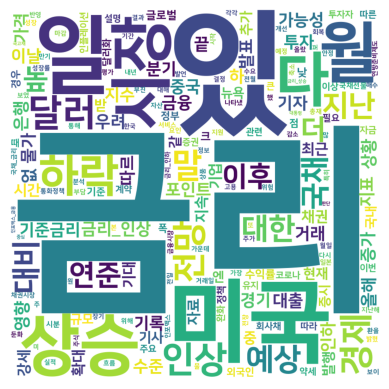

In [26]:
# MPB_워드 클라우드
wc = WordCloud(font_path=r'\wsl.localhost\Ubuntu-20.04\usr\share\fonts\truetype\nanum/NanumSquareEB.ttf', width=400, height=400, scale=2.0, 
               max_font_size=250, background_color="white")
gen = wc.generate_from_frequencies(vecotor_self_dict)
plt.axis("off")

plt.imshow(gen)

In [231]:
#모델 테스트
#모델 훈련 데이터 가져오기

X = train_df['new_column'].tolist() #전처리된 문장들 토큰
y = train_df['label'].tolist() #각 문장의 라벨
print(f'X_데이터 길이: {len(X)} ,Y_데이터 길이:{len(y)}')
print("학습물 읽기")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(len(X_train), len(X_test), len(y_train), len(y_test))
print(len(X_train)+len(X_test), len(y_train)+len(y_test))
print("학습 데이터 테스트 데이터 분리")

vectorizer = TfidfVectorizer()
X_train_counts = vectorizer.fit_transform(X_train)
X_test_counts = vectorizer.transform(X_test)

print("벡터라이즈를 생성하였습니다")

print("학습을 시작합니다")

clf = MultinomialNB()
clf.fit(X_train_counts, y_train)

print(f"정확성: {clf.score(X_train_counts, y_train)}")

print("예측을 시작합니다")
target_text = [file_text]
target_text_counts = vectorizer.transform(target_text)
predicted_labels = clf.predict(target_text_counts)
print(predicted_labels)

X_데이터 길이: 154446 ,Y_데이터 길이:154446
학습물 읽기
108112 46334 108112 46334
154446 154446
학습 데이터 테스트 데이터 분리
벡터라이즈를 생성하였습니다
학습을 시작합니다
정확성: 0.7495560159834246
예측을 시작합니다
['doveish']


In [232]:
#모델 평가 점수

y_train_pred = clf.predict(X_train_counts)
y_test_pred = clf.predict(X_test_counts)

#Accuracy = (올바른 예측 수) / (전체 예측 수)
#Precision = (올바르게 분류된 문장 수) / (올바르게 분류된 전체 샘플 수)
#Recall = (양성으로 올바르게 분류된 샘플 수) / (실제로 양성인 전체 샘플 수)
#F1 Score = 2 * ((Precision * Recall) / (Precision + Recall))
#F1 Score 를 계산 할때 수학의 조화평균을 이용합니다 (뭔지는 이해가 안됨...;;)
# 결국 F1 Score 가 해당 모델의 정확성을 나타냅니다

print(f"학습 데이터 doveishAccuracy: {accuracy_score(y_train, y_train_pred)}")
print(f"학습 데이터 doveish Precision: {precision_score(y_train, y_train_pred, pos_label='doveish')}")
print(f"학습 데이터 doveish Recall: {recall_score(y_train, y_train_pred, pos_label='doveish')}")
print(f"학습 데이터 doveish F1 Score: {f1_score(y_train, y_train_pred, pos_label='doveish')}")


print(f"테스트 데이터 doveish Accuracy: {accuracy_score(y_test, y_test_pred)}")
print(f"테스트 데이터 doveish Precision: {precision_score(y_test, y_test_pred, pos_label='doveish')}")
print(f"테스트 데이터 doveish Recall: {recall_score(y_test,y_test_pred,pos_label='doveish')}")
print(f"테스트 데이터 doveish F1 Score: {f1_score(y_test,y_test_pred,pos_label='doveish')}")


print(f"학습 데이터 hawkish Accuracy: {accuracy_score(y_train, y_train_pred)}")
print(f"학습 데이터 hawkish Precision: {precision_score(y_train, y_train_pred, pos_label='hawkish')}")
print(f"학습 데이터 hawkish Recall: {recall_score(y_train, y_train_pred, pos_label='hawkish')}")
print(f"학습 데이터 hawkish F1 Score: {f1_score(y_train, y_train_pred, pos_label='hawkish')}")


print(f"테스트 데이터 hawkish Accuracy: {accuracy_score(y_test, y_test_pred)}")
print(f"테스트 데이터 hawkish Precision: {precision_score(y_test, y_test_pred, pos_label='hawkish')}")
print(f"테스트 데이터 hawkish Recall: {recall_score(y_test,y_test_pred,pos_label='hawkish')}")
print(f"테스트 데이터 hawkish F1 Score: {f1_score(y_test,y_test_pred,pos_label='hawkish')}")

학습 데이터 doveishAccuracy: 0.7495560159834246
학습 데이터 doveish Precision: 0.7316432396251673
학습 데이터 doveish Recall: 0.7984186114458931
학습 데이터 doveish F1 Score: 0.7635738111454567
테스트 데이터 doveish Accuracy: 0.6706953856779039
테스트 데이터 doveish Precision: 0.6604442344045368
테스트 데이터 doveish Recall: 0.7164829530889516
테스트 데이터 doveish F1 Score: 0.6873232509529078
학습 데이터 hawkish Accuracy: 0.7495560159834246
학습 데이터 hawkish Precision: 0.7716950694904037
학습 데이터 hawkish Recall: 0.6994001874414245
학습 데이터 hawkish F1 Score: 0.7337712139387622
테스트 데이터 hawkish Accuracy: 0.6706953856779039
테스트 데이터 hawkish Precision: 0.6831248209340082
테스트 데이터 hawkish Recall: 0.6239532449406838
테스트 데이터 hawkish F1 Score: 0.6521996808753133


In [35]:
#실제 모델

# 모델 훈련 데이터 리스트화
X = train_df['new_column'].tolist() # 전처리된 문장들 토큰
y = train_df['label'].tolist() # 각 문장의 라벨

# 현재 저희 데이터는 0~특정까지는 비둘기적이고 특정~마지막 까지 로 연속되어있습니다

shuffle_data = list(zip(X, y))
random.shuffle(shuffle_data)

# 다시 분리합니다.
X_shuffled, y_shuffled = zip(*shuffle_data)

print(f'X_데이터 길이: {len(X_shuffled)}, Y_데이터 길이: {len(y_shuffled)}')
print("학습물 읽기")

vectorizer = TfidfVectorizer()
X_train_counts = vectorizer.fit_transform(X_shuffled)

print("벡터라이즈를 생성하였습니다")

print("학습을 시작합니다")

clf = MultinomialNB()
clf.fit(X_train_counts, y_shuffled)

print(f"정확성: {clf.score(X_train_counts, y_shuffled)}")

print("예측을 시작합니다")
target_text = [file_text]
target_text_counts = vectorizer.transform(target_text)
predicted_labels = clf.predict(target_text_counts)
print(predicted_labels)


X_데이터 길이: 154446, Y_데이터 길이: 154446
학습물 읽기
벡터라이즈를 생성하였습니다
학습을 시작합니다
정확성: 0.7366199189360683
예측을 시작합니다
['doveish']


In [36]:
#모델 평가 점수

y_train_pred = clf.predict(X_train_counts)

#Accuracy = (올바른 예측 수) / (전체 예측 수)
#Precision = (올바르게 분류된 문장 수) / (올바르게 분류된 전체 샘플 수)
#Recall = (양성으로 올바르게 분류된 샘플 수) / (실제로 양성인 전체 샘플 수)
#F1 Score = 2 * ((Precision * Recall) / (Precision + Recall))
#F1 Score 를 계산 할때 수학의 조화평균을 이용합니다 (뭔지는 이해가 안됨...;;)
# 결국 F1 Score 가 해당 모델의 정확성을 나타냅니다

print(f"총합 데이터 doveish Accuracy: {accuracy_score(y_shuffled, y_train_pred)}")

print(f"총합 데이터 doveish Precision: {precision_score(y_shuffled, y_train_pred, pos_label='doveish')}")

print(f"총합 데이터 doveish Recall: {recall_score(y_shuffled, y_train_pred, pos_label='doveish')}")

print(f"총합 데이터 doveish F1 Score: {f1_score(y_shuffled, y_train_pred, pos_label='doveish')}")

print(f"총합 데이터 hawkish Accuracy: {accuracy_score(y_shuffled, y_train_pred)}")

print(f"총합 데이터 hawkish Precision: {precision_score(y_shuffled, y_train_pred, pos_label='hawkish')}")

print(f"총합 데이터 hawkish Recall: {recall_score(y_shuffled, y_train_pred, pos_label='hawkish')}")

print(f"총합 데이터 hawkish F1 Score: {f1_score(y_shuffled, y_train_pred, pos_label='hawkish')}")

총합 데이터 doveish Accuracy: 0.7366199189360683
총합 데이터 doveish Precision: 0.7208672086720868
총합 데이터 doveish Recall: 0.7826732166615494
총합 데이터 doveish F1 Score: 0.750499883462751
총합 데이터 hawkish Accuracy: 0.7366199189360683
총합 데이터 hawkish Precision: 0.7558353455214442
총합 데이터 hawkish Recall: 0.6894255224311072
총합 데이터 hawkish F1 Score: 0.7211046663101458


In [39]:
predictions_total_ngram_df = pd.read_csv('./predictions_MPB.csv')
predictions_total_ngram_df

,doc_name,words,label,1_ngrams,2_ngrams,3_ngrams,4_ngrams,5_ngrams,new_column
0,2013-05-09.txt,국내외 경제동향 관련 일부위원 성장률 지난해 이 해도 그칠 예상 따라 저성장 기조 ...,doveish,국내외 경제동향 관련 일부위원 성장률 지난해 이 해도 그칠 예상 따라 저성장 기조 ...,국내외_경제동향 경제동향_관련 관련_일부위원 일부위원_성장률 성장률_지난해 지난해_...,국내외_경제동향_관련 경제동향_관련_일부위원 관련_일부위원_성장률 일부위원_성장률_...,국내외_경제동향_관련_일부위원 경제동향_관련_일부위원_성장률 관련_일부위원_성장률_...,국내외_경제동향_관련_일부위원_성장률 경제동향_관련_일부위원_성장률_지난해 관련_일...,국내외 경제동향 관련 일부위원 성장률 지난해 이 해도 그칠 예상 따라 저성장 기조 ...
1,2013-06-13.txt,국내외 경제동향 관련 일부위원 최근 소득 여건 소비 심리 개선 불구 높 가계 부채 ...,doveish,국내외 경제동향 관련 일부위원 최근 소득 여건 소비 심리 개선 불구 높 가계 부채 ...,국내외_경제동향 경제동향_관련 관련_일부위원 일부위원_최근 최근_소득 소득_여건 여...,국내외_경제동향_관련 경제동향_관련_일부위원 관련_일부위원_최근 일부위원_최근_소득...,국내외_경제동향_관련_일부위원 경제동향_관련_일부위원_최근 관련_일부위원_최근_소득...,국내외_경제동향_관련_일부위원_최근 경제동향_관련_일부위원_최근_소득 관련_일부위원...,국내외 경제동향 관련 일부위원 최근 소득 여건 소비 심리 개선 불구 높 가계 부채 ...
2,2013-06-27.txt,일부위원 최근 은행 중소기업 대출 정부 중소기업 대출 확대 노력 은행 완화 대출태도...,doveish,일부위원 최근 은행 중소기업 대출 정부 중소기업 대출 확대 노력 은행 완화 대출태도...,일부위원_최근 최근_은행 은행_중소기업 중소기업_대출 대출_정부 정부_중소기업 중소...,일부위원_최근_은행 최근_은행_중소기업 은행_중소기업_대출 중소기업_대출_정부 대출...,일부위원_최근_은행_중소기업 최근_은행_중소기업_대출 은행_중소기업_대출_정부 중소...,일부위원_최근_은행_중소기업_대출 최근_은행_중소기업_대출_정부 은행_중소기업_대출...,일부위원 최근 은행 중소기업 대출 정부 중소기업 대출 확대 노력 은행 완화 대출태도...
3,2014-01-09.txt,국내외 경제동향 관련 먼저 일부위원 올해 경제 성장 모멘텀 측면 경제주체 정도 성장...,doveish,국내외 경제동향 관련 먼저 일부위원 올해 경제 성장 모멘텀 측면 경제주체 정도 성장...,국내외_경제동향 경제동향_관련 관련_먼저 먼저_일부위원 일부위원_올해 올해_경제 경...,국내외_경제동향_관련 경제동향_관련_먼저 관련_먼저_일부위원 먼저_일부위원_올해 일...,국내외_경제동향_관련_먼저 경제동향_관련_먼저_일부위원 관련_먼저_일부위원_올해 먼...,국내외_경제동향_관련_먼저_일부위원 경제동향_관련_먼저_일부위원_올해 관련_먼저_일...,국내외 경제동향 관련 먼저 일부위원 올해 경제 성장 모멘텀 측면 경제주체 정도 성장...
4,2014-02-13.txt,국내외 경제동향 관련 먼저 일부위원 부동산시장 정책 방향 관련 수출 내수 불균형 지...,doveish,국내외 경제동향 관련 먼저 일부위원 부동산시장 정책 방향 관련 수출 내수 불균형 지...,국내외_경제동향 경제동향_관련 관련_먼저 먼저_일부위원 일부위원_부동산시장 부동산시...,국내외_경제동향_관련 경제동향_관련_먼저 관련_먼저_일부위원 먼저_일부위원_부동산시...,국내외_경제동향_관련_먼저 경제동향_관련_먼저_일부위원 관련_먼저_일부위원_부동산시...,국내외_경제동향_관련_먼저_일부위원 경제동향_관련_먼저_일부위원_부동산시장 관련_먼...,국내외 경제동향 관련 먼저 일부위원 부동산시장 정책 방향 관련 수출 내수 불균형 지...
...,...,...,...,...,...,...,...,...,...
146,2023-03-09.txt,관련부서 안건 관련 위원 협의회 논의 내용 다음 같이 보 하 먼저 위원 사전 협의 ...,hawkish,관련부서 안건 관련 위원 협의회 논의 내용 다음 같이 보 하 먼저 위원 사전 협의 ...,관련부서_안건 안건_관련 관련_위원 위원_협의회 협의회_논의 논의_내용 내용_다음 ...,관련부서_안건_관련 안건_관련_위원 관련_위원_협의회 위원_협의회_논의 협의회_논의...,관련부서_안건_관련_위원 안건_관련_위원_협의회 관련_위원_협의회_논의 위원_협의회...,관련부서_안건_관련_위원_협의회 안건_관련_위원_협의회_논의 관련_위원_협의회_논의...,관련부서 안건 관련 위원 협의회 논의 내용 다음 같이 보 하 먼저 위원 사전 협의 ...
147,2023-03-23.txt,관련부서 안건 관련 월일 개최 위원 협의회 논의 주요 내용 다음 같이 보 하 먼저 ...,hawkish,관련부서 안건 관련 월일 개최 위원 협의회 논의 주요 내용 다음 같이 보 하 먼저 ...,관련부서_안건 안건_관련 관련_월일 월일_개최 개최_위원 위원_협의회 협의회_논의 ...,관련부서_안건_관련 안건_관련_월일 관련_월일_개최 월일_개최_위원 개최_위원_협의...,관련부서_안건_관련_월일 안건_관련_월일_개최 관련_월일_개최_위원 월일_개최_위원...,관련부서_안건_관련_월일_개최 안건_관련_월일_개최_위원 관련_월일_개최_위원_협의...,관련부서 안건 관련 월일 개최 위원 협의회 논의 주요 내용 다음 같이 보 하 먼저 ...
148,2023-04-11.txt,전일 개최 동향 회의 다음 같 토의 있 경제 상황 평가 월 일부위원 미국 경우 은행...,hawkish,전일 개최 동향 회의 다음 같 토의 있 경제 상황 평가 월 일부위원 미국 경우 은행...,전일_개최 개최_동향 동향_회의 회의_다음 다음_같 같_토의 토의_있 있_경제 경제...,전일_개최_동향 개최_동향_회의 동향_회의_다음 회의_다음_같 다음_같_토의 같_토...,전일_개최_동향_회의 개최_동향_회의_다음 동향_회의_다음_같 회의_다음_같_토의 ...,전일_개최_동향_회의_다음 개최_동향_회의_다음_같 동향_회의_다음_같_토의 회의_...,전일 개최 동향 회의 다음 같 토의 있 경제 상황 평가 월 일부위원 미국 경우 은행...
149,2023-07-13.txt,전일 개최 동향 회의 다음 같 토의 있 경제 상황 평가 월 일부위원 올해 미국 경제...,hawkish,전일 개최 동향 회의 다음 같 토의 있 경제 상황 평가 월 일부위원 올해 미국 경제...,전일_개최 개최_동향 동향_회의 회의_다음 다음_같 같_토의 토의_있 있_경제 경제...,전일_개최_동향 개최_동향_회의 동향_회의_다음 회의_다음_같 다음_같_토의 같_토...,전일_개최_동향_회의 개최_동향_회의_다음 동향_회의_다음_같 회의_다음_같_토의 ...,전일_개최_동향_회의_다음 개최_동향_회의_다음_같 동향_회의_다음_같_토의 회의_...,전일 개최 동향 회의 다음 같 토의 있 경제 상황 평가 월 일부위원 올해 미국 경제...


In [44]:
predictions_count = {}
for nrams in predictions_total_ngram_df["new_column"]:
    target = nrams.split()
    for token in target:
        if token in predictions_count.keys():
            predictions_count[token] += 1
        else:
            predictions_count[token] = 1
predictions_count

{'국내외': 548,
 '경제동향': 107,
 '관련': 2608,
 '일부위원': 2394,
 '성장률': 1493,
 '지난해': 533,
 '이': 945,
 '해도': 18,
 '그칠': 29,
 '예상': 1873,
 '따라': 1259,
 '저성장': 97,
 '기조': 878,
 '장기': 1088,
 '대한': 3030,
 '우려': 1338,
 '많': 372,
 '지적': 744,
 '후': 1135,
 '같': 1436,
 '국면': 155,
 '경기순환': 56,
 '요인': 2343,
 '구조적': 560,
 '중': 1602,
 '주로': 358,
 '기인': 523,
 '보': 1517,
 '물': 1251,
 '대해': 3086,
 '관련부서': 3871,
 '우리나라': 1558,
 '차지': 152,
 '수출': 2204,
 '비중': 383,
 '매우': 400,
 '높': 3106,
 '대외': 823,
 '여건': 1443,
 '개선': 1556,
 '국내': 2023,
 '경기': 3302,
 '따라서': 85,
 '부진': 1391,
 '없': 1046,
 '설명': 800,
 '지금': 225,
 '상황': 3898,
 '이후': 1671,
 '선진국': 608,
 '지속': 2809,
 '점': 3137,
 '측면': 1211,
 '강한': 52,
 '생각': 957,
 '아울러': 844,
 '소비': 2186,
 '가계': 3054,
 '부채': 1649,
 '문제': 952,
 '고령화': 140,
 '일부': 1123,
 '가세': 67,
 '보인다고': 1220,
 '답변': 2196,
 '동위원': 2987,
 '민간': 823,
 '성장': 1636,
 '평균': 248,
 '근접': 126,
 '대폭': 40,
 '하락': 2111,
 '올해': 409,
 '다시': 373,
 '회복': 1655,
 '보이': 1854,
 '동기간': 15,
 '자체': 213,
 '크': 2266,
 '반사': 

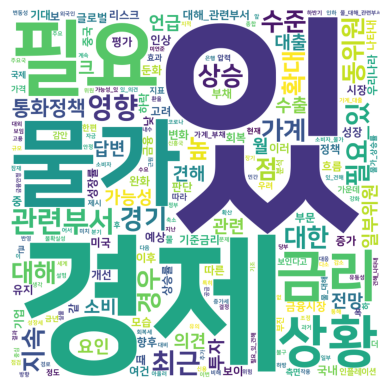

In [45]:
# MPB_워드 클라우드
wc = WordCloud(font_path=r'\wsl.localhost\Ubuntu-20.04\usr\share\fonts\truetype\nanum/NanumSquareEB.ttf', width=400, height=400, scale=2.0, 
               max_font_size=250, background_color="white")
gen = wc.generate_from_frequencies(predictions_count)
plt.axis("off")

plt.imshow(gen)

In [72]:
len(y_shuffled), len(y_train_pred)

(154446, 154446)

In [202]:
#전체 문서 예측

# 예측할 문서들의 리스트
doc_list = predictions_total_ngram_df['new_column'].tolist() #전처리된 문장들 토큰
label_list = predictions_total_ngram_df['label'].tolist() #각 문장의 라벨
doc_name_list = predictions_total_ngram_df['doc_name'].tolist() #각 문장의 파일명

# class_mapping[pred]

# 예측 결과 저장할 리스트 초기화
predicted_labels = []
score_list = []
# 각 문서에 대한 예측 수행
for text in doc_list:
    target_text_counts = vectorizer.transform([text])
    predicted_label = clf.predict(target_text_counts)
    predicted_labels.append(predicted_label[0])
    score = clf.predict_proba(target_text_counts)
    score = score[0]
    doveish_score = score[0]
    hawkish_score = score[1]
    if doveish_score > hawkish_score:
        answer = doveish_score
        wrong_answer = hawkish_score
    else:
        answer = hawkish_score
        wrong_answer = doveish_score
    score_list.append([predicted_label[0],doveish_score,hawkish_score,answer,wrong_answer])
    
    
# 실제 라벨 설정
true_labels = label_list

# 정확성 계산
accuracy = accuracy_score(true_labels, predicted_labels)

# 정확성 출력
print(f"정확성: {accuracy}")



정확성: 0.6225165562913907


In [203]:
doveish_score = [score[1] for score in score_list]
hawkish_score = [score[2] for score in score_list]
answer_score = [score[3] for score in score_list]
wrong_answer = [score[4] for score in score_list]

In [129]:
predictions_total_ngram_df["hawkish_score"] = hawkish_score
predictions_total_ngram_df["doveish_score"] = doveish_score
predictions_total_ngram_df["wrong_answer"] = wrong_answer
predictions_total_ngram_df["answer_score"] = answer_score

In [206]:
predictions_total_ngram_df.head()

,doc_name,words,label,1_ngrams,2_ngrams,3_ngrams,4_ngrams,5_ngrams,new_column,model_result,answer,hawkish_score,doveish_score,answer_score,wrong_answer
0,2013-05-09.txt,국내외 경제동향 관련 일부위원 성장률 지난해 이 해도 그칠 예상 따라 저성장 기조 ...,doveish,국내외 경제동향 관련 일부위원 성장률 지난해 이 해도 그칠 예상 따라 저성장 기조 ...,국내외_경제동향 경제동향_관련 관련_일부위원 일부위원_성장률 성장률_지난해 지난해_...,국내외_경제동향_관련 경제동향_관련_일부위원 관련_일부위원_성장률 일부위원_성장률_...,국내외_경제동향_관련_일부위원 경제동향_관련_일부위원_성장률 관련_일부위원_성장률_...,국내외_경제동향_관련_일부위원_성장률 경제동향_관련_일부위원_성장률_지난해 관련_일...,국내외 경제동향 관련 일부위원 성장률 지난해 이 해도 그칠 예상 따라 저성장 기조 ...,doveish,True,0.299131,0.700869,0.700869,0.299131
1,2013-06-13.txt,국내외 경제동향 관련 일부위원 최근 소득 여건 소비 심리 개선 불구 높 가계 부채 ...,doveish,국내외 경제동향 관련 일부위원 최근 소득 여건 소비 심리 개선 불구 높 가계 부채 ...,국내외_경제동향 경제동향_관련 관련_일부위원 일부위원_최근 최근_소득 소득_여건 여...,국내외_경제동향_관련 경제동향_관련_일부위원 관련_일부위원_최근 일부위원_최근_소득...,국내외_경제동향_관련_일부위원 경제동향_관련_일부위원_최근 관련_일부위원_최근_소득...,국내외_경제동향_관련_일부위원_최근 경제동향_관련_일부위원_최근_소득 관련_일부위원...,국내외 경제동향 관련 일부위원 최근 소득 여건 소비 심리 개선 불구 높 가계 부채 ...,doveish,True,0.267616,0.732384,0.732384,0.267616
2,2013-06-27.txt,일부위원 최근 은행 중소기업 대출 정부 중소기업 대출 확대 노력 은행 완화 대출태도...,doveish,일부위원 최근 은행 중소기업 대출 정부 중소기업 대출 확대 노력 은행 완화 대출태도...,일부위원_최근 최근_은행 은행_중소기업 중소기업_대출 대출_정부 정부_중소기업 중소...,일부위원_최근_은행 최근_은행_중소기업 은행_중소기업_대출 중소기업_대출_정부 대출...,일부위원_최근_은행_중소기업 최근_은행_중소기업_대출 은행_중소기업_대출_정부 중소...,일부위원_최근_은행_중소기업_대출 최근_은행_중소기업_대출_정부 은행_중소기업_대출...,일부위원 최근 은행 중소기업 대출 정부 중소기업 대출 확대 노력 은행 완화 대출태도...,doveish,True,0.447262,0.552738,0.552738,0.447262
3,2014-01-09.txt,국내외 경제동향 관련 먼저 일부위원 올해 경제 성장 모멘텀 측면 경제주체 정도 성장...,doveish,국내외 경제동향 관련 먼저 일부위원 올해 경제 성장 모멘텀 측면 경제주체 정도 성장...,국내외_경제동향 경제동향_관련 관련_먼저 먼저_일부위원 일부위원_올해 올해_경제 경...,국내외_경제동향_관련 경제동향_관련_먼저 관련_먼저_일부위원 먼저_일부위원_올해 일...,국내외_경제동향_관련_먼저 경제동향_관련_먼저_일부위원 관련_먼저_일부위원_올해 먼...,국내외_경제동향_관련_먼저_일부위원 경제동향_관련_먼저_일부위원_올해 관련_먼저_일...,국내외 경제동향 관련 먼저 일부위원 올해 경제 성장 모멘텀 측면 경제주체 정도 성장...,doveish,True,0.239896,0.760104,0.760104,0.239896
4,2014-02-13.txt,국내외 경제동향 관련 먼저 일부위원 부동산시장 정책 방향 관련 수출 내수 불균형 지...,doveish,국내외 경제동향 관련 먼저 일부위원 부동산시장 정책 방향 관련 수출 내수 불균형 지...,국내외_경제동향 경제동향_관련 관련_먼저 먼저_일부위원 일부위원_부동산시장 부동산시...,국내외_경제동향_관련 경제동향_관련_먼저 관련_먼저_일부위원 먼저_일부위원_부동산시...,국내외_경제동향_관련_먼저 경제동향_관련_먼저_일부위원 관련_먼저_일부위원_부동산시...,국내외_경제동향_관련_먼저_일부위원 경제동향_관련_먼저_일부위원_부동산시장 관련_먼...,국내외 경제동향 관련 먼저 일부위원 부동산시장 정책 방향 관련 수출 내수 불균형 지...,doveish,True,0.196830,0.803170,0.803170,0.196830


In [54]:
predictions_total_ngram_df["model_result"] = predicted_labels
predictions_total_ngram_df

,doc_name,words,label,1_ngrams,2_ngrams,3_ngrams,4_ngrams,5_ngrams,new_column,model_result
0,2013-05-09.txt,국내외 경제동향 관련 일부위원 성장률 지난해 이 해도 그칠 예상 따라 저성장 기조 ...,doveish,국내외 경제동향 관련 일부위원 성장률 지난해 이 해도 그칠 예상 따라 저성장 기조 ...,국내외_경제동향 경제동향_관련 관련_일부위원 일부위원_성장률 성장률_지난해 지난해_...,국내외_경제동향_관련 경제동향_관련_일부위원 관련_일부위원_성장률 일부위원_성장률_...,국내외_경제동향_관련_일부위원 경제동향_관련_일부위원_성장률 관련_일부위원_성장률_...,국내외_경제동향_관련_일부위원_성장률 경제동향_관련_일부위원_성장률_지난해 관련_일...,국내외 경제동향 관련 일부위원 성장률 지난해 이 해도 그칠 예상 따라 저성장 기조 ...,doveish
1,2013-06-13.txt,국내외 경제동향 관련 일부위원 최근 소득 여건 소비 심리 개선 불구 높 가계 부채 ...,doveish,국내외 경제동향 관련 일부위원 최근 소득 여건 소비 심리 개선 불구 높 가계 부채 ...,국내외_경제동향 경제동향_관련 관련_일부위원 일부위원_최근 최근_소득 소득_여건 여...,국내외_경제동향_관련 경제동향_관련_일부위원 관련_일부위원_최근 일부위원_최근_소득...,국내외_경제동향_관련_일부위원 경제동향_관련_일부위원_최근 관련_일부위원_최근_소득...,국내외_경제동향_관련_일부위원_최근 경제동향_관련_일부위원_최근_소득 관련_일부위원...,국내외 경제동향 관련 일부위원 최근 소득 여건 소비 심리 개선 불구 높 가계 부채 ...,doveish
2,2013-06-27.txt,일부위원 최근 은행 중소기업 대출 정부 중소기업 대출 확대 노력 은행 완화 대출태도...,doveish,일부위원 최근 은행 중소기업 대출 정부 중소기업 대출 확대 노력 은행 완화 대출태도...,일부위원_최근 최근_은행 은행_중소기업 중소기업_대출 대출_정부 정부_중소기업 중소...,일부위원_최근_은행 최근_은행_중소기업 은행_중소기업_대출 중소기업_대출_정부 대출...,일부위원_최근_은행_중소기업 최근_은행_중소기업_대출 은행_중소기업_대출_정부 중소...,일부위원_최근_은행_중소기업_대출 최근_은행_중소기업_대출_정부 은행_중소기업_대출...,일부위원 최근 은행 중소기업 대출 정부 중소기업 대출 확대 노력 은행 완화 대출태도...,doveish
3,2014-01-09.txt,국내외 경제동향 관련 먼저 일부위원 올해 경제 성장 모멘텀 측면 경제주체 정도 성장...,doveish,국내외 경제동향 관련 먼저 일부위원 올해 경제 성장 모멘텀 측면 경제주체 정도 성장...,국내외_경제동향 경제동향_관련 관련_먼저 먼저_일부위원 일부위원_올해 올해_경제 경...,국내외_경제동향_관련 경제동향_관련_먼저 관련_먼저_일부위원 먼저_일부위원_올해 일...,국내외_경제동향_관련_먼저 경제동향_관련_먼저_일부위원 관련_먼저_일부위원_올해 먼...,국내외_경제동향_관련_먼저_일부위원 경제동향_관련_먼저_일부위원_올해 관련_먼저_일...,국내외 경제동향 관련 먼저 일부위원 올해 경제 성장 모멘텀 측면 경제주체 정도 성장...,doveish
4,2014-02-13.txt,국내외 경제동향 관련 먼저 일부위원 부동산시장 정책 방향 관련 수출 내수 불균형 지...,doveish,국내외 경제동향 관련 먼저 일부위원 부동산시장 정책 방향 관련 수출 내수 불균형 지...,국내외_경제동향 경제동향_관련 관련_먼저 먼저_일부위원 일부위원_부동산시장 부동산시...,국내외_경제동향_관련 경제동향_관련_먼저 관련_먼저_일부위원 먼저_일부위원_부동산시...,국내외_경제동향_관련_먼저 경제동향_관련_먼저_일부위원 관련_먼저_일부위원_부동산시...,국내외_경제동향_관련_먼저_일부위원 경제동향_관련_먼저_일부위원_부동산시장 관련_먼...,국내외 경제동향 관련 먼저 일부위원 부동산시장 정책 방향 관련 수출 내수 불균형 지...,doveish
...,...,...,...,...,...,...,...,...,...,...
146,2023-03-09.txt,관련부서 안건 관련 위원 협의회 논의 내용 다음 같이 보 하 먼저 위원 사전 협의 ...,hawkish,관련부서 안건 관련 위원 협의회 논의 내용 다음 같이 보 하 먼저 위원 사전 협의 ...,관련부서_안건 안건_관련 관련_위원 위원_협의회 협의회_논의 논의_내용 내용_다음 ...,관련부서_안건_관련 안건_관련_위원 관련_위원_협의회 위원_협의회_논의 협의회_논의...,관련부서_안건_관련_위원 안건_관련_위원_협의회 관련_위원_협의회_논의 위원_협의회...,관련부서_안건_관련_위원_협의회 안건_관련_위원_협의회_논의 관련_위원_협의회_논의...,관련부서 안건 관련 위원 협의회 논의 내용 다음 같이 보 하 먼저 위원 사전 협의 ...,hawkish
147,2023-03-23.txt,관련부서 안건 관련 월일 개최 위원 협의회 논의 주요 내용 다음 같이 보 하 먼저 ...,hawkish,관련부서 안건 관련 월일 개최 위원 협의회 논의 주요 내용 다음 같이 보 하 먼저 ...,관련부서_안건 안건_관련 관련_월일 월일_개최 개최_위원 위원_협의회 협의회_논의 ...,관련부서_안건_관련 안건_관련_월일 관련_월일_개최 월일_개최_위원 개최_위원_협의...,관련부서_안건_관련_월일 안건_관련_월일_개최 관련_월일_개최_위원 월일_개최_위원...,관련부서_안건_관련_월일_개최 안건_관련_월일_개최_위원 관련_월일_개최_위원_협의...,관련부서 안건 관련 월일 개최 위원 협의회 논의 주요 내용 다음 같이 보 하 먼저 ...,hawkish
148,2023-04-11.txt,전일 개최 동향 회의 다음 같 토의 있 경제 상황 평가 월 일부위원 미국 경우 은행...,hawkish,전일 개최 동향 회의 다음 같 토의 있 경제 상황 평가 월 일부위원 미국 경우 은행...,전일_개최 개최_동향 동향_회의 회의_다음 다음_같 같_토의 토의_있 있_경제 경제...,전일_개최_동향 개최_동향_회의 동향_회의_다음 회의_다음_같 다음_같_토의 같_토...,전일_개최_동향_회의 개최_동향_회의_다음 동향_회의_다음_같 회의_다음_같_토의 ...,전일_개최_동향_회의_다음 개최_동향_회의_다음_같 동향_회의_다음_같_토의 회의_...,전일 개최 동향 회의 다음 같 토의 있 경제 상황 평가 월 일부위원 미국 경우 은행...,hawkish
149,2023-07-13.txt,전일 개최 동향 회의 다음 같 토의 있 경제 상황 평가 월 일부위원 올해 미국 경제...,hawkish,전일 개최 동향 회의 다음 같 토의 있 경제 상황 평가 월 일부위원 올해 미국 경제...,전일_개최 개최_동향 동향_회의 회의_다음 다음_같 같_토의 토의_있 있_경제 경제...,전일_개최_동향 개최_동향_회의 동향_회의_다음 회의_다음_같 다음_같_토의 같_토...,전일_개최_동향_회의 개최_동향_회의_다음 동향_회의_다음_같 회의_다음_같_토의 ...,전일_개최_동향_회의_다음 개최_동향_회의_다음_같 동향_회의_다음_같_토의 회의_...,전일 개최 동향 회의 다음 같 토의 있 경제 상황 평가 월 일부위원 올해 미국 경제...,hawkish


In [172]:
predictions_total_ngram_df['answer'] = predictions_total_ngram_df['label'] == predictions_total_ngram_df['model_result']

predictions_total_ngram_df

,doc_name,words,label,1_ngrams,2_ngrams,3_ngrams,4_ngrams,5_ngrams,new_column,model_result,answer,hawkish_score,doveish_score
0,2013-05-09.txt,국내외 경제동향 관련 일부위원 성장률 지난해 이 해도 그칠 예상 따라 저성장 기조 ...,doveish,국내외 경제동향 관련 일부위원 성장률 지난해 이 해도 그칠 예상 따라 저성장 기조 ...,국내외_경제동향 경제동향_관련 관련_일부위원 일부위원_성장률 성장률_지난해 지난해_...,국내외_경제동향_관련 경제동향_관련_일부위원 관련_일부위원_성장률 일부위원_성장률_...,국내외_경제동향_관련_일부위원 경제동향_관련_일부위원_성장률 관련_일부위원_성장률_...,국내외_경제동향_관련_일부위원_성장률 경제동향_관련_일부위원_성장률_지난해 관련_일...,국내외 경제동향 관련 일부위원 성장률 지난해 이 해도 그칠 예상 따라 저성장 기조 ...,doveish,True,0.299131,0.700869
1,2013-06-13.txt,국내외 경제동향 관련 일부위원 최근 소득 여건 소비 심리 개선 불구 높 가계 부채 ...,doveish,국내외 경제동향 관련 일부위원 최근 소득 여건 소비 심리 개선 불구 높 가계 부채 ...,국내외_경제동향 경제동향_관련 관련_일부위원 일부위원_최근 최근_소득 소득_여건 여...,국내외_경제동향_관련 경제동향_관련_일부위원 관련_일부위원_최근 일부위원_최근_소득...,국내외_경제동향_관련_일부위원 경제동향_관련_일부위원_최근 관련_일부위원_최근_소득...,국내외_경제동향_관련_일부위원_최근 경제동향_관련_일부위원_최근_소득 관련_일부위원...,국내외 경제동향 관련 일부위원 최근 소득 여건 소비 심리 개선 불구 높 가계 부채 ...,doveish,True,0.267616,0.732384
2,2013-06-27.txt,일부위원 최근 은행 중소기업 대출 정부 중소기업 대출 확대 노력 은행 완화 대출태도...,doveish,일부위원 최근 은행 중소기업 대출 정부 중소기업 대출 확대 노력 은행 완화 대출태도...,일부위원_최근 최근_은행 은행_중소기업 중소기업_대출 대출_정부 정부_중소기업 중소...,일부위원_최근_은행 최근_은행_중소기업 은행_중소기업_대출 중소기업_대출_정부 대출...,일부위원_최근_은행_중소기업 최근_은행_중소기업_대출 은행_중소기업_대출_정부 중소...,일부위원_최근_은행_중소기업_대출 최근_은행_중소기업_대출_정부 은행_중소기업_대출...,일부위원 최근 은행 중소기업 대출 정부 중소기업 대출 확대 노력 은행 완화 대출태도...,doveish,True,0.447262,0.552738
3,2014-01-09.txt,국내외 경제동향 관련 먼저 일부위원 올해 경제 성장 모멘텀 측면 경제주체 정도 성장...,doveish,국내외 경제동향 관련 먼저 일부위원 올해 경제 성장 모멘텀 측면 경제주체 정도 성장...,국내외_경제동향 경제동향_관련 관련_먼저 먼저_일부위원 일부위원_올해 올해_경제 경...,국내외_경제동향_관련 경제동향_관련_먼저 관련_먼저_일부위원 먼저_일부위원_올해 일...,국내외_경제동향_관련_먼저 경제동향_관련_먼저_일부위원 관련_먼저_일부위원_올해 먼...,국내외_경제동향_관련_먼저_일부위원 경제동향_관련_먼저_일부위원_올해 관련_먼저_일...,국내외 경제동향 관련 먼저 일부위원 올해 경제 성장 모멘텀 측면 경제주체 정도 성장...,doveish,True,0.239896,0.760104
4,2014-02-13.txt,국내외 경제동향 관련 먼저 일부위원 부동산시장 정책 방향 관련 수출 내수 불균형 지...,doveish,국내외 경제동향 관련 먼저 일부위원 부동산시장 정책 방향 관련 수출 내수 불균형 지...,국내외_경제동향 경제동향_관련 관련_먼저 먼저_일부위원 일부위원_부동산시장 부동산시...,국내외_경제동향_관련 경제동향_관련_먼저 관련_먼저_일부위원 먼저_일부위원_부동산시...,국내외_경제동향_관련_먼저 경제동향_관련_먼저_일부위원 관련_먼저_일부위원_부동산시...,국내외_경제동향_관련_먼저_일부위원 경제동향_관련_먼저_일부위원_부동산시장 관련_먼...,국내외 경제동향 관련 먼저 일부위원 부동산시장 정책 방향 관련 수출 내수 불균형 지...,doveish,True,0.196830,0.803170
...,...,...,...,...,...,...,...,...,...,...,...,...,...
146,2023-03-09.txt,관련부서 안건 관련 위원 협의회 논의 내용 다음 같이 보 하 먼저 위원 사전 협의 ...,hawkish,관련부서 안건 관련 위원 협의회 논의 내용 다음 같이 보 하 먼저 위원 사전 협의 ...,관련부서_안건 안건_관련 관련_위원 위원_협의회 협의회_논의 논의_내용 내용_다음 ...,관련부서_안건_관련 안건_관련_위원 관련_위원_협의회 위원_협의회_논의 협의회_논의...,관련부서_안건_관련_위원 안건_관련_위원_협의회 관련_위원_협의회_논의 위원_협의회...,관련부서_안건_관련_위원_협의회 안건_관련_위원_협의회_논의 관련_위원_협의회_논의...,관련부서 안건 관련 위원 협의회 논의 내용 다음 같이 보 하 먼저 위원 사전 협의 ...,hawkish,True,0.607515,0.392485
147,2023-03-23.txt,관련부서 안건 관련 월일 개최 위원 협의회 논의 주요 내용 다음 같이 보 하 먼저 ...,hawkish,관련부서 안건 관련 월일 개최 위원 협의회 논의 주요 내용 다음 같이 보 하 먼저 ...,관련부서_안건 안건_관련 관련_월일 월일_개최 개최_위원 위원_협의회 협의회_논의 ...,관련부서_안건_관련 안건_관련_월일 관련_월일_개최 월일_개최_위원 개최_위원_협의...,관련부서_안건_관련_월일 안건_관련_월일_개최 관련_월일_개최_위원 월일_개최_위원...,관련부서_안건_관련_월일_개최 안건_관련_월일_개최_위원 관련_월일_개최_위원_협의...,관련부서 안건 관련 월일 개최 위원 협의회 논의 주요 내용 다음 같이 보 하 먼저 ...,hawkish,True,0.503140,0.496860
148,2023-04-11.txt,전일 개최 동향 회의 다음 같 토의 있 경제 상황 평가 월 일부위원 미국 경우 은행...,hawkish,전일 개최 동향 회의 다음 같 토의 있 경제 상황 평가 월 일부위원 미국 경우 은행...,전일_개최 개최_동향 동향_회의 회의_다음 다음_같 같_토의 토의_있 있_경제 경제...,전일_개최_동향 개최_동향_회의 동향_회의_다음 회의_다음_같 다음_같_토의 같_토...,전일_개최_동향_회의 개최_동향_회의_다음 동향_회의_다음_같 회의_다음_같_토의 ...,전일_개최_동향_회의_다음 개최_동향_회의_다음_같 동향_회의_다음_같_토의 회의_...,전일 개최 동향 회의 다음 같 토의 있 경제 상황 평가 월 일부위원 미국 경우 은행...,hawkish,True,0.672141,0.327859
149,2023-07-13.txt,전일 개최 동향 회의 다음 같 토의 있 경제 상황 평가 월 일부위원 올해 미국 경제...,hawkish,전일 개최 동향 회의 다음 같 토의 있 경제 상황 평가 월 일부위원 올해 미국 경제...,전일_개최 개최_동향 동향_회의 회의_다음 다음_같 같_토의 토의_있 있_경제 경제...,전일_개최_동향 개최_동향_회의 동향_회의_다음 회의_다음_같 다음_같_토의 같_토...,전일_개최_동향_회의 개최_동향_회의_다음 동향_회의_다음_같 회의_다음_같_토의 ...,전일_개최_동향_회의_다음 개최_동향_회의_다음_같 동향_회의_다음_같_토의 회의_...,전일 개최 동향 회의 다음 같 토의 있 경제 상황 평가 월 일부위원 올해 미국 경제...,hawkish,True,0.750372,0.249628


In [211]:
True_doc_name_list = predictions_total_ngram_df["doc_name"].loc[predictions_total_ngram_df["answer"] == True].tolist()
answer_score_list = predictions_total_ngram_df["answer_score"].loc[predictions_total_ngram_df["answer"] == True].tolist()
False_doc_name_list = predictions_total_ngram_df["doc_name"].loc[predictions_total_ngram_df["answer"] == False].tolist()
wrong_answer_score_list = predictions_total_ngram_df["wrong_answer"].loc[predictions_total_ngram_df["answer"] == False].tolist()

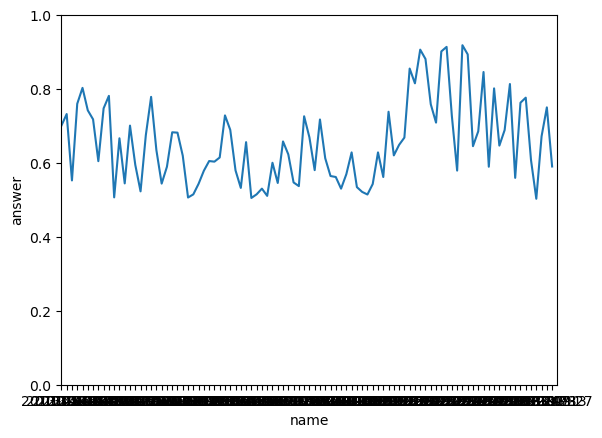

In [228]:
import matplotlib.pyplot as plt

plt.plot([i[:10] for i in True_doc_name_list], answer_score_list)
plt.xlabel('name')
plt.ylabel('answer')
plt.xlim([0, len(True_doc_name_list)])      # X축의 범위: [xmin, xmax]
plt.ylim([0.00000, 1.0000])     # Y축의 범위: [ymin, ymax]

plt.show()

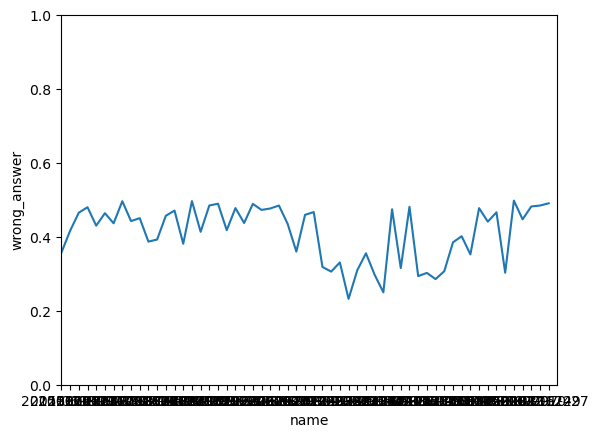

In [229]:
import matplotlib.pyplot as plt

plt.plot([i[:10] for i in False_doc_name_list], wrong_answer_score_list)
plt.xlabel('name')
plt.ylabel('wrong_answer')
plt.xlim([0, len(False_doc_name_list)])      # X축의 범위: [xmin, xmax]
plt.ylim([0.00000, 1.0000])     # Y축의 범위: [ymin, ymax]

plt.show()